In [1]:
# initial setup
try:
    # settings colab:
    import google.colab
    
    # si usan colab, deben cambiar el token de esta url
    #! mkdir -p ../data
    # los que usan colab deben modificar el token de esta url:
    #! wget -O ../data/properati_2017.csv https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_students_2020/master/M2/CLASE_07_Pandas_2/Data/resultado-de-encuestas-2017-2018.csv?token=AA4GFHO3EKGWGILBCV4BISC6WR6B4
    
except ModuleNotFoundError:    
    # settings local:
    %run "common/base_setup.py"

Running command `conda list`... ok
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
plotly=4.6.0 already installed
Running command `conda install --yes chart-studio=1.1.0`... error
    
PackagesNotFoundError: The following packages are not available from current channels:

  - chart-studio=1.1.0

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.





## Carga Inicial del Dataset

In [2]:
# sudo apt-get install libproj-dev proj-data proj-bin libgeos-dev
# pip install --upgrade nbformat
# pip install geoplot beautifulsoup4

import pandas as pd
import numpy as np

import geopandas
import geoplot
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [3]:
# low_memorybool, default True
# Internally process the file in chunks, resulting in lower memory use while parsing, 
# but possibly mixed type inference. To ensure no mixed types either set False, 
# or specify the type with the dtype parameter. 
# Note that the entire file is read into a single DataFrame regardless, 
# use the chunksize or iterator parameter to return the data in chunks. (Only valid with C parser).
raw_data = pd.read_csv("./data/properati-fase0.csv", sep = ",", low_memory=False)
geonames = pd.read_csv("./data/AR.txt", sep = "\t", header=None, low_memory=False)
geonames = geonames[[0, 4, 5]]
geonames.rename(columns={0:'geonames_id', 4: 'gn_lat', 5: 'gn_lon'}, inplace=True)

# categories
raw_data['property_type'] = raw_data['property_type'].astype('category')
raw_data['country_name']  = raw_data['country_name'].astype('category')
raw_data['state_name']    = raw_data['state_name'].astype('category')
raw_data['place_name']    = raw_data['place_name'].mask(
    raw_data['place_name'].isna(), 'Tigre').astype('category')

print("Total de registros: {0}".format(raw_data.shape[0]))
print("Total de registros sin ubicar: {0}".format(raw_data["lat"].isna().sum()))

Total de registros: 121197
Total de registros sin ubicar: 51529


## Geonames

In [4]:
# compute NA using geonames
df = pd.merge(raw_data, geonames, on='geonames_id', how='left', left_index=True)
df['c_lat']  = df['lat'].fillna(df['gn_lat'])
df['c_lng']  = df['lon'].fillna(df['gn_lon'])

places = df['place_with_parent_names'].str.strip('|').str.split('|', n=5, expand=True)
df['c_pais']   = places[0]
df['c_estado'] = places[1]

cities = {
    'J A de la Peña': 'Pergamino',
}
df['c_localidad'] = places[2].fillna(places[1]).replace(
    to_replace=cities.keys(), value=cities.values())

provinces = {
    'Capital Federal'             : 'Buenos Aires',
    'Bs.As. G.B.A. Zona Sur'      : 'Buenos Aires',
    'Buenos Aires Costa Atlántica': 'Buenos Aires',
    'Bs.As. G.B.A. Zona Norte'    : 'Buenos Aires',
    'Bs.As. G.B.A. Zona Oeste'    : 'Buenos Aires',
    'Buenos Aires Interior'       : 'Buenos Aires',
    'Misiones'           : 'Misiones', 
    'Entre Ríos'         : 'Entre Ríos', 
    'Santa Fe'           : 'Santa Fe',
    'Córdoba'            : 'Córdoba',
    'Salta'              : 'Salta',
    'Neuquén'            : 'Neuquén',
    'Río Negro'          : 'Río Negro',
    'San Luis'           : 'San Luis',
    'Mendoza'            : 'Mendoza',
    'Corrientes'         : 'Corrientes',
    'Chubut'             : 'Chubut',
    'Tucumán'            : 'Tucumán',
    'La Pampa'           : 'La Pampa',
    'Chaco'              : 'Chaco',
    'San Juan'           : 'San Juan',
    'Santa Cruz'         : 'Santa Cruz',
    'Tierra Del Fuego'   : 'Tierra Del Fuego',
    'Catamarca'          : 'Catamarca',
    'Santiago Del Estero': 'Santiago Del Estero',
    'Jujuy'              : 'Jujuy',
    'La Rioja'           : 'La Rioja',
    'Formosa'            : 'Formosa',
}
df['c_provincia'] = places[1].map(provinces)

# some fixes
df.loc[df['c_localidad'] == 'Agua Blanca',    ['c_provincia', 'c_estado']] = ['La Rioja', 'La Rioja']
df.loc[df['c_localidad'] == 'Alejandro Roca', ['c_provincia', 'c_estado']] = ['Córdoba', 'Córdoba']

df.reset_index(inplace=True)

## Outliers

### Gráfica con **outliers**

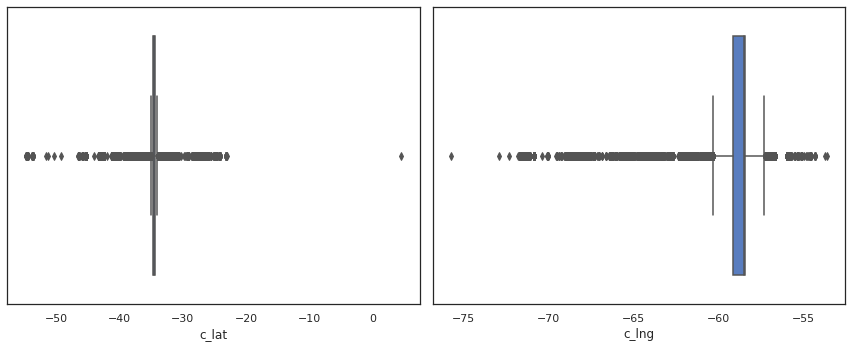

In [5]:
def plot_outliers(dataset):
    sns.set(style="white", palette="muted", color_codes=True)
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    sns.boxplot(x=dataset['c_lat'], ax=axes[0])
    sns.boxplot(x=dataset['c_lng'], ax=axes[1])
    plt.setp(axes, yticks=[])
    plt.tight_layout()
plot_outliers(df)

### Gráfica sin **outliers**

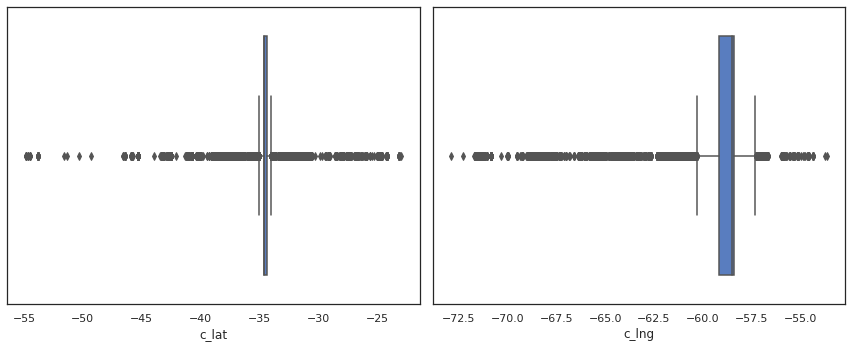

In [6]:
c_lat_max = df['c_lat'].max()
c_lng_min = df['c_lng'].min()
outliers  = df[(df['c_lat'] == c_lat_max) | (df['c_lng'] == c_lng_min)]
df.loc[outliers.index, ['c_lat', 'c_lng']] = [np.nan, np.nan]

plot_outliers(df)

## Tratamiento de NA

Construimos un mapa usando los nombre de localidad como claves y los siguientes valores:
1. Si la localidad tiene registros con coordenadas provistas, entonces el valor es la moda de cada columna para esa localidad.
2. Caso contrario, buscamos las coordenadas de la localidad en internet y las proporcionamos a mano.

Y lo usamos para resolver los valores faltantes.

In [7]:
## fillna manual
### Desamparados - San Juan
df.loc[df['Unnamed: 0'] == 21980,  ['c_lat', 'c_lng']] = [-31.5319663, -68.5651964]
df.loc[df['Unnamed: 0'] == 21981,  ['c_lat', 'c_lng']] = [-31.5331104, -68.5686797]
df.loc[df['Unnamed: 0'] == 23122,  ['c_lat', 'c_lng']] = [-31.5184376, -68.5482754]
df.loc[df['Unnamed: 0'] == 28571,  ['c_lat', 'c_lng']] = [-31.5308862, -68.5314857]
df.loc[df['Unnamed: 0'] == 40083,  ['c_lat', 'c_lng']] = [-31.5304557, -68.5615639]
df.loc[df['Unnamed: 0'] == 110058, ['c_lat', 'c_lng']] = [-31.5454204, -68.5430692]
df.loc[df['Unnamed: 0'] == 110059, ['c_lat', 'c_lng']] = [-31.5383650, -68.5351764]
### Tucumán
df.loc[df['Unnamed: 0'] == 67890, ['c_lat', 'c_lng']] = [26.84155790, -65.2313618]
df.loc[df['Unnamed: 0'] == 93446, ['c_lat', 'c_lng']] = [-26.8216742, -65.1981297]
df.loc[df['Unnamed: 0'] == 68636, ['c_lat', 'c_lng']] = [-26.8266789, -65.19948]
df.loc[df['Unnamed: 0'] == 82233, ['c_lat', 'c_lng']] = [-26.8279032, -65.2229815]
df.loc[df['Unnamed: 0'] == 85715, ['c_lat', 'c_lng']] = [-26.7959479,-65.2516876]

## mask for rows with missing coordinates
missing_coordinates = df['c_lat'].isna()

## get a list of all cities that have at least one row without coordinates
missing_places = df.loc[missing_coordinates, ['c_pais', 'c_provincia', 'c_localidad']].drop_duplicates()
unique_places  = np.unique(missing_places['c_localidad'])

## build a frequency table (total of rows and total of na)
total   = df[df['c_localidad'].isin(unique_places)].groupby('c_localidad').size()
missing = df[missing_coordinates].groupby('c_localidad').size()
freq    = pd.concat([missing, total], axis=1)

## get the list of cities that don't have coordinates registered
non_localized_places = freq[freq[0] == freq[1]].index

## get the list of cities that already have some coordinates
localized_places = list(set(unique_places) - set(non_localized_places))

## fillna for case 1
def __filtered(dataset, place):
    mask = dataset['c_localidad'] == place
    cols = ['c_lat', 'c_lng']
    return dataset.loc[mask, cols]

def mood(dataset, place):
    return __filtered(dataset, place).mode().values[0]

def mean(dataset, place):
    return __filtered(dataset, place).mean(axis=0).values

def median(dataset, place):
    return __filtered(dataset, place).median(axis=0).values

def compute(dataset, place, size):
    if size == 1:
        return mean(dataset, place)
    return (np.nan, np.nan)

na_by_places = { place: __filtered(df, place)['c_lat'].isna().sum() for place in localized_places }
coords_dict  = { place: compute(df, place, size) for place, size in na_by_places.items() if size == 1 }

## fillna for case 2
coords_dict['Agua Blanca']    = (-28.965278, -67.000278)
coords_dict['Desvío Arijón']  = (-31.8667,   -60.8833)
coords_dict['Cabalango']      = (-31.393056, -64.558889)
coords_dict['Alejandro Roca'] = (-33.35,     -63.716667)
coords_dict['Los Laureles']   = (-29.3681,   -59.7369)
coords_dict['Santa Luisa']    = (-31.6917,   -59.9083)
coords_dict['Arroyo Ceibal']  = (-28.7239,   -59.4769)
coords_dict['La Serranita']   = (-31.735,    -64.458889)
coords_dict['Mi Granja']      = (-31.348056, -64)
### Caso Tucumán - Todos los anuncios dicen estar ubicados en la capital
coords_dict['Tucumán'] = (-26.8328417, -65.292634) # San Miguel de Tucumán

## fillna effectivelly
for place, coords in coords_dict.items():
    df.loc[df['c_localidad'] == place, ['c_lat', 'c_lng']] = coords

## Visualización

In [8]:
counts = df.groupby('c_provincia').size().sort_values(ascending=False)
counts

c_provincia
Buenos Aires           93426
Córdoba                12070
Santa Fe               10170
Río Negro                808
Neuquén                  733
Mendoza                  681
Tucumán                  674
Corrientes               583
Misiones                 464
Entre Ríos               368
Salta                    278
Chubut                   259
San Luis                 252
La Pampa                 157
Formosa                   65
Chaco                     57
San Juan                  40
Tierra Del Fuego          31
Catamarca                 26
Jujuy                     26
Santa Cruz                20
La Rioja                   5
Santiago Del Estero        4
dtype: int64

Vemos que Buenos Aires, Córdoba y Santa Fé son los lugares con más anuncios publicados por lo que dividimos el gráfico de barras en 2 gráficos para observar la distribución de anuncios a lo largo del país.

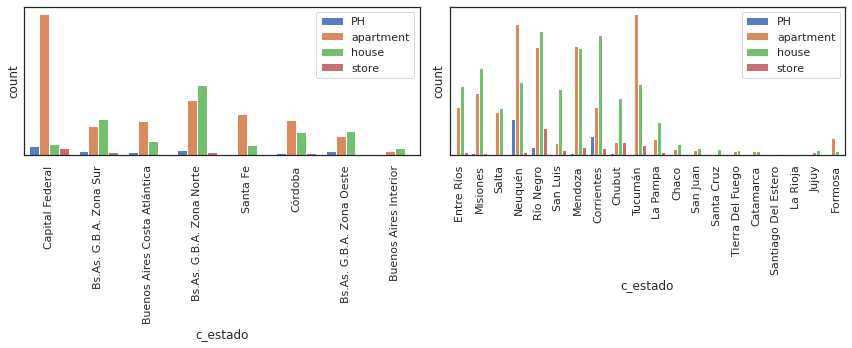

In [9]:
top_provinces = counts.head(3).index.values
top_regions   = df['c_provincia'].isin(top_provinces)

_, axes   = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
countplt1 = sns.countplot(x="c_estado",
                          hue="property_type",
                          data=df[top_regions],
                          ax=axes[0])
countplt2 = sns.countplot(x="c_estado",
                          hue="property_type",
                          data=df[~top_regions],
                          ax=axes[1])

countplt1.set_xticklabels(countplt1.get_xticklabels(), rotation=90)
countplt2.set_xticklabels(countplt2.get_xticklabels(), rotation=90)

countplt1.legend(loc='upper right')
countplt2.legend(loc='upper right')

plt.setp(axes, yticks=[])
plt.tight_layout()

Finalmente, graficamos el plot.

/home/rafael-garcia/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


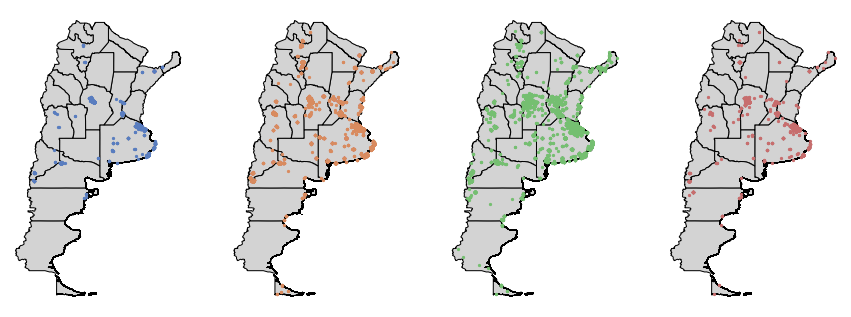

In [10]:
figsize    = plt.rcParams["figure.figsize"]
figsize[0] = 15
figsize[1] = 10
plt.rcParams["figure.figsize"] = figsize

shpfile   = './data/gadm36_ARG_shp/gadm36_ARG_1.shp'
prjfile   = './data/gadm36_ARG_shp/gadm36_ARG_1.prj'
provinces = geopandas.read_file(shpfile)
with open(prjfile) as prj_file:
    provinces.crs = prj_file.read()

coords    = df[['c_lat', 'c_lng', 'property_type']].copy()
geometry  = [Point(x, y) for x, y in zip(coords['c_lng'], coords['c_lat'])]
geodf     = geopandas.GeoDataFrame(coords, crs=provinces.crs, geometry=geometry)
geodf     = geopandas.sjoin(geodf, provinces, how='left', op='within')
fig, axs  = plt.subplots(1, 4)
for ax in axs:
    ax.set_aspect('equal')
    ax.axis('off')
    provinces.plot(ax=ax, color='lightgrey', edgecolor='black')
geodf[df['property_type'] == 'PH'       ].plot(ax=axs[0], color='#597DBF', markersize=5)
geodf[df['property_type'] == 'apartment'].plot(ax=axs[1], color='#D98B5F', markersize=5)
geodf[df['property_type'] == 'house'    ].plot(ax=axs[2], color='#75BF71', markersize=5)
geodf[df['property_type'] == 'store'    ].plot(ax=axs[3], color='#C76E6E', markersize=5)

plt.show()

Y la cantidad de registros sin ubicar, logramos bajarla a:

In [11]:
print("Total de registros sin ubicar: {0}".format(df['c_lat'].isna().sum()))

Total de registros sin ubicar: 8247


In [12]:
df.to_csv('./data/properati-fase1.csv', sep=',', index=False)